# Machine Learning Engineer Nanodegree

## Capstone Project: Classification of Top-wear (primarily T-Shirts) into different Categories

### Motivation

This notebook contains the code (defined as steps) and tries to work out an algorithm to classify a given set of images of T-Shirts into 24 different categories. The notebook is divided into steps and each step helps in building up the solution to the problem given above. The code accepts user-supplied image/s as input. If a t-shirt is detected in the given image, the algorithm tries to categorize the image in one of the 24 pre-defined categories.

### Steps

The notebook is divided into steps. The links below help in navigation to the steps defined.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect T-Shirts
* [Step 2](#step2): Basic CNN (w/o transfer learning) to Classify Graphic Types 
* [Step 3](#step4): Transfer Learning CNN to Graphic Types on T-Shirts
* [Step 4](#step5): Algorithm Implementation
* [Step 5](#step6): Testing the algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

The code cell below, imports a dataset of t-shirt images, and populates a few variables using functions from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `graphic_types` - list of string-valued graphic type names for translating labels


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    tshirt_files = np.array(data['filenames'])
    tshirt_targets = np_utils.to_categorical(np.array(data['target']), 24)
    return tshirt_files, tshirt_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('capstone_images/train')
valid_files, valid_targets = load_dataset('capstone_images/valid')
test_files, test_targets = load_dataset('capstone_images/test')

# load list of graphic types of tshirts
graphic_types = [item[20:-1] for item in sorted(glob("capstone_images/train/*/"))]

# print statistics about the dataset
print("There are %d total tshirts' graphic categories." % len(graphic_types))
print('There are %s total tshirt images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training tshirt images.' % len(train_files))
print('There are %d validation tshirt images.' % len(valid_files))
print('There are %d test tshirt images.'% len(test_files))

Using TensorFlow backend.
/Users/14981/anaconda2/envs/dog-project/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


There are 24 total tshirts' graphic categories.
There are 11816 total tshirt images.

There are 6676 training tshirt images.
There are 1580 validation tshirt images.
There are 3560 test tshirt images.


---
<a id='step1'></a>
## Step 1: Detect T-Shirt

In this section, a pre-trained model named [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006)  is used to detect t-shirts in images. The ResNet-50 model, along with weights trained on [ImageNet](http://www.image-net.org/), which is a very large, very popular dataset used for image classification and other vision tasks is downloaded. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [2]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since I'm working with color images, each image has three channels. Likewise, since I'm processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths. It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

The 4D tensor returned by the function defined above is then pre-processed before being fed to the ResNet50 model. The pre-processing step converts the RGB image tensor to BGR tensor i.e. re-orders the channels in the given tensor. Then the pixels are normalized by subtracting the mean pixel value ($[103.939, 116.779, 123.68]$ in RGB calculated from all images present in ImageNet) and then division by the max-value of a pixel which is $[255]$. All this is done using a `preprocess_input` function which is part of Keras ResNet library.

Now that we're ready with the tensor data for the input image, we call the `predict` function of the ResNet50 model. The predict function returns an array (of size 1000) and each array location contains the probability of the input image belonging to a certain category. 

The code cell below implements the function described.

Now that I have a way to format a image for supplying to ResNet-50, I'm now ready to use the model to extract the predictions. This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category. This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, I obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [4]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a T-Shirt Detector

As mentioned [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the category corresponding to t-shirts corresponds to key 610. Thus, a t-shirt is detected in case the function `ResNet50_predict_labels` defined in the above cell outputs the value as 610.

The `detect_tshirt` function below, returns `True` if a t-shirt is detected in an image (and `False` if not) based on the above description.

In [5]:
### returns "True" if a t-shirt is detected in the image stored at img_path
def detect_tshirt(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return (prediction == 610) 

#### Plotting RGB histograms of two images from the train-set
Below is the function to plot RGB histogram for an image

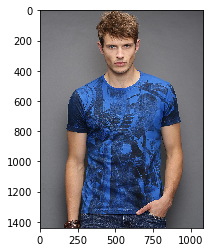

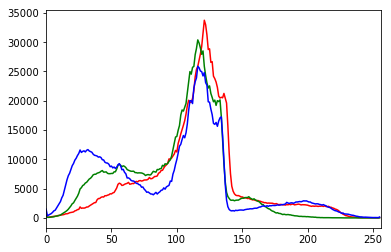

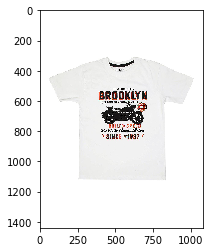

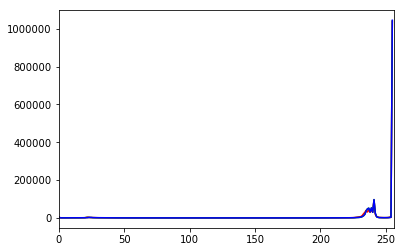

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def plot_image_hist(image_path): 
    img = cv2.imread(image_path)
    color = ('r','g','b')
    plt.figure()
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()
    
plot_image_hist('capstone_images/train/01.Biker/Moda-Rapido-Blue-Printed-T-Shirt_1_ffde2be531f6dde8f5600d7e66cccddf.jpg')
plot_image_hist('capstone_images/train/01.Biker/Inmark-Boys-Tops_b08c320f9345dd7bb9963b77186ca4f6_images.jpg')

---
<a id='step2'></a>
## Basic CNN (w/o transfer learning) to Classify Graphic Types 

In this section, a basic CNN is defined to classify/predict the graphic type of the input image. The cells above which define functions to load images, detect t-shirts in the images will be used in this and later sections of the notebook.

The basic CNN model using Conv2D layers defined in this section serves as the benchmark model. It is imperative to mention that this model is expected to have low accuracy as the number of epochs and the image-set is not as exhaustive as it was supposed to be because of lack of compute power as the whole notebook is run on a Mac. 


### Pre-process the Data
The images are pre-processed as mentioned in the Step 1 using the functions defined thereby.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 3560/3560 [02:36<00:00, 22.75it/s]


### Model Architecture Implementation

CNN to classify graphic type of a t-shirt.

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                 input_shape=train_tensors.shape[1:]))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
# model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(24, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
average_pooling2d_3 (Average (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 111, 111, 32)      2080      
_________________________________________________________________
average_pooling2d_4 (Average (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 54, 54, 64)        8256      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

### Compile the Model

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Using model checkpointing to save the model that attains the best validation loss.


In [27]:
from keras.callbacks import ModelCheckpoint  
import tensorflow as tf
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
epochs = 5
with tf.device("/gpu:0"):
    model.fit(train_tensors, train_targets, 
              validation_data=(valid_tensors, valid_targets),
              epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6676 samples, validate on 1580 samples
Epoch 1/5
6676/6676 [==============================] - 95s - loss: 2.3033 - acc: 0.3071 - val_loss: 3.2665 - val_acc: 0.1968
Epoch 2/5
6676/6676 [==============================] - 99s - loss: 2.1947 - acc: 0.3391 - val_loss: 3.4804 - val_acc: 0.1468
Epoch 3/5
6676/6676 [==============================] - 97s - loss: 2.0648 - acc: 0.4061 - val_loss: 3.5105 - val_acc: 0.1582
Epoch 4/5
6676/6676 [==============================] - 99s - loss: 2.0345 - acc: 0.4188 - val_loss: 3.7244 - val_acc: 0.1462
Epoch 5/5
6676/6676 [==============================] - 99s - loss: 2.0202 - acc: 0.4170 - val_loss: 3.7799 - val_acc: 0.1234


### Loading the best Model saved above

In [29]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Finding the accuracy of the model on the test-dataset.

In [30]:
# get index of predicted t-shirt graphic type for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 18.9045%


---
<a id='step3'></a>
## Step 3: Transfer Learning CNN to Graphic Types on T-Shirts (using ResNet50)

This step uses transfer learning to create a CNN to classify images into 24 categories based on their graphic type. The CNN developed aims to achieve an accuracy of at least 30%.

### (IMPLEMENTATION) Obtain Bottleneck Features

The code in the cell below loads the bottleneck features for ResNet50 model contianed in the file named `CapstoneResnet50Data.npz`.

In [6]:
bottleneck_features = np.load('capstone_features/CapstoneResnet50Data.npz')
train_features = bottleneck_features['train']
valid_features = bottleneck_features['valid']
test_features = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN(based on ResNet50) using transfer learning  to classify graphic type of a t-shirt.

---
### Model Architecture 1: 
#### Uses an interim dense layer with droput and an output dense layers

Create a CNN(based on ResNet50) using transfer learning  to classify graphic type of a t-shirt.

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

resnet_model = Sequential()
resnet_model.add(Flatten(input_shape=train_features.shape[1:]))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(24, activation='softmax'))
resnet_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                12312     
Total params: 1,061,400.0
Trainable params: 1,061,400.0
Non-trainable params: 0.0
_________________________________________________________________


In [8]:
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.dense_tl.hdf5', verbose=1, save_best_only=True)
epochs = 20
history_resnet = resnet_model.fit(train_features, train_targets, validation_data=(valid_features, valid_targets), 
                   epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6676 samples, validate on 1580 samples
Epoch 1/20
6676/6676 [==============================] - 6s - loss: 2.3290 - acc: 0.2945 - val_loss: 3.3783 - val_acc: 0.1968
Epoch 2/20
6676/6676 [==============================] - 4s - loss: 2.2791 - acc: 0.3143 - val_loss: 3.6021 - val_acc: 0.1968
Epoch 3/20
6676/6676 [==============================] - 4s - loss: 2.2685 - acc: 0.3135 - val_loss: 3.2960 - val_acc: 0.1968
Epoch 4/20
6676/6676 [==============================] - 5s - loss: 2.2682 - acc: 0.3144 - val_loss: 3.5397 - val_acc: 0.1968
Epoch 5/20
6676/6676 [==============================] - 5s - loss: 2.2620 - acc: 0.3140 - val_loss: 3.4771 - val_acc: 0.1968
Epoch 6/20
6676/6676 [==============================] - 4s - loss: 2.2550 - acc: 0.3140 - val_loss: 3.6972 - val_acc: 0.1968
Epoch 7/20
6676/6676 [==============================] - 5s - loss: 2.2583 - acc: 0.3141 - val_loss: 3.6344 - val_acc: 0.1968
Epoch 8/20
6676/6676 [==============================] - 4s - loss: 2.2541 - a

### Model Architecture: 
#### Uses just a GAP layer and an output dense layer thereafter

Create a CNN(based on ResNet50) using transfer learning  to classify graphic type of a t-shirt.

In [10]:
resnet_gap = Sequential()
resnet_gap.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
resnet_gap.add(Dense(24, activation='softmax'))
resnet_gap.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                49176     
Total params: 49,176.0
Trainable params: 49,176.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [11]:
resnet_gap.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Use model checkpointing to save the model that attains the best validation loss.  


In [12]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.tl.hdf5', verbose=1, save_best_only=True)

history_gap = resnet_gap.fit(train_features, train_targets, 
                                validation_data=(valid_features, valid_targets), 
                               epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6676 samples, validate on 1580 samples
Epoch 1/20
6676/6676 [==============================] - 2s - loss: 2.3024 - acc: 0.2982 - val_loss: 3.3758 - val_acc: 0.1968
Epoch 2/20
6676/6676 [==============================] - 2s - loss: 2.2656 - acc: 0.3062 - val_loss: 3.3772 - val_acc: 0.1962
Epoch 3/20
6676/6676 [==============================] - 1s - loss: 2.2558 - acc: 0.2969 - val_loss: 3.6836 - val_acc: 0.1968
Epoch 4/20
6676/6676 [==============================] - 1s - loss: 2.2498 - acc: 0.3071 - val_loss: 3.5292 - val_acc: 0.1968
Epoch 5/20
6676/6676 [==============================] - 1s - loss: 2.2421 - acc: 0.3096 - val_loss: 3.4951 - val_acc: 0.1854
Epoch 6/20
6676/6676 [==============================] - 1s - loss: 2.2426 - acc: 0.3072 - val_loss: 3.4226 - val_acc: 0.1968
Epoch 7/20
6676/6676 [==============================] - 1s - loss: 2.2389 - acc: 0.3125 - val_loss: 3.5112 - val_acc: 0.0038
Epoch 8/20
6676/6676 [==============================] - 2s - loss: 2.2377 - a

dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


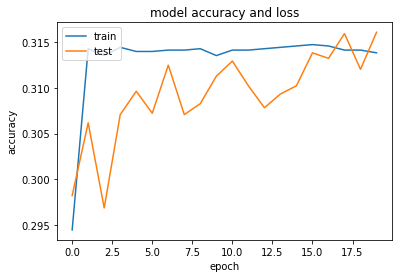

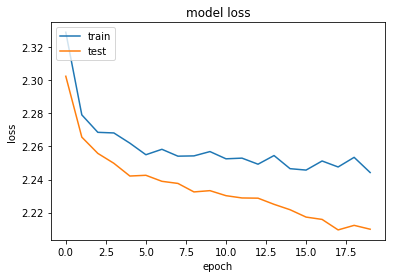

In [19]:
# Plot the error and the traning graph
import matplotlib.pyplot as plt
history = history_resnet
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history_gap.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history_gap.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### (IMPLEMENTATION) Load the Model with the Best Validation Loss and Testing it

Getting the test accuracy for Model Architecture 1.

In [20]:
#resnet_model.load_weights('saved_models/weights.best.dense_tl.hdf5')

dense_predictions = [np.argmax(resnet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_features]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(dense_predictions)==np.argmax(test_targets, axis=1)) / len(dense_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 29.0911%


### (IMPLEMENTATION) Load the Model with the Best Validation Loss and Testing it

Getting the test accuracy for Model Architecture 2.

In [21]:
resnet_gap.load_weights('saved_models/weights.best.tl.hdf5')

gap_predictions = [np.argmax(resnet_gap.predict(np.expand_dims(feature, axis=0))) for feature in test_features]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(gap_predictions)==np.argmax(test_targets, axis=1)) / len(gap_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 31.1151%


### Confusion matrix for the above two models and their respective predictions
The function below plots a confusion matrix given the matrix, classes and the titles.

In [79]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.show()

In [80]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=2)
cm_dense = confusion_matrix(np.argmax(test_targets, axis=1), np.array(dense_predictions))
plt.figure(figsize = (20,10))
plot_confusion_matrix(cm_dense, classes=graphic_types, title='Confusion matrix for Dense layered CNN')
cm_gap = confusion_matrix(np.argmax(test_targets, axis=1), np.array(gap_predictions))
plt.figure(figsize = (20,10))
plot_confusion_matrix(cm_gap, classes=graphic_types,
                      title='Confusion matrix for GAP layered CNN')


### (IMPLEMENTATION) Predict Graphic Type of a T-Shirt with the Model

A function that takes an image path as input and returns the graphic type of the t-shirt that is predicted by the model.  

Similar to the analogous function in Step 4, the function has three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector. Note that the argmax of this prediction vector gives the index of the predicted graphic type of the t-shirt.
3. Using the `graphic_types` array defined in Step 0 of this notebook to return the corresponding graphic type.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell. To obtain the bottleneck features corresponding to the chosen CNN architecture, the function call is

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [13]:
### Function that takes a path to an image as input
### and returns the graphic type of a t-shirt that is predicted by the model.
from extract_bottleneck_features import *

def resnet_predict_graphic(img_path):
    return getLabelFromPrediction(get_prediction_value(img_path))

def get_prediction_value(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = resnet_gap.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return np.argmax(predicted_vector)

def getLabelFromPrediction(value):
    return graphic_types[value]


---
<a id='step5'></a>
## Step 5: Write an Algorithm

An algorithm that accepts a file path to an image and first determines whether the image contains a t-shirt or not.  Then,
- if a __t-shirt__ is detected in the image, return the predicted graphic type.
- if __not__ is detected in the image, provide output that indicates an error.


### (IMPLEMENTATION) Algorithm

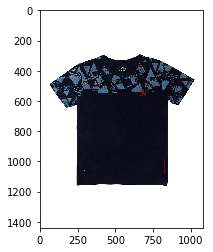

Detected a t-shirt with the graphic type as n/12.Solid


In [14]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from extract_bottleneck_features import *

def tshirt_graphic_type_detector(img_path):
    graphic_type = resnet_predict_graphic(img_path) 
    
    # Display the image
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    # Detect what it is
    if detect_tshirt(img_path):
        print("Detected a t-shirt with the graphic type as " + str(graphic_type))
    else:
        print("Unable to detect t-shirt, can't predict graphic type as well")

tshirt_graphic_type_detector(train_files[0])

---
<a id='step6'></a>
## Step 6: Testing the Algorithm

In this section, the algorithm is fed negative and positive inputs and the algorithm tries to detect the graphic type of the t-shirt if a t-shirt is present in the image

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!


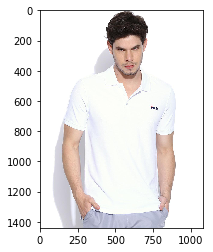

Unable to detect t-shirt, can't predict graphic type as well


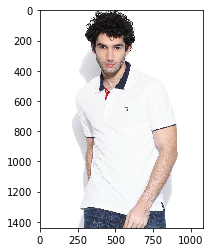

Unable to detect t-shirt, can't predict graphic type as well


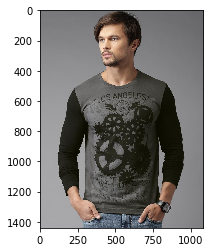

Unable to detect t-shirt, can't predict graphic type as well


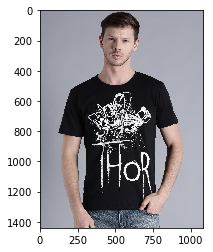

Detected a t-shirt with the graphic type as n/12.Solid


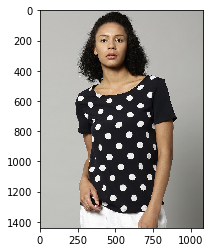

Detected a t-shirt with the graphic type as n/12.Solid


In [15]:
sample_images = np.array(glob("sampleImages/*"))
for path in sample_images:
    tshirt_graphic_type_detector(path)